<a href="https://colab.research.google.com/github/anirbanghoshsbi/.github.io/blob/master/work/work_from_here/GET_FII_Data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install yfinance --q

In [2]:
import plotly.express as px
import plotly.graph_objects as go
import warnings
warnings.simplefilter(action='ignore', category=Warning)
import yfinance as yf

In [3]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
import numpy as np
import pandas as pd
#from pykalman import KalmanFilter
#import pandas_ta as ta

In [4]:
nifty=yf.download('^NSEI',start='2018-08-07')
nif=nifty.reset_index()

[*********************100%***********************]  1 of 1 completed


In [5]:
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator,YearLocator

In [6]:
content_path='https://raw.githubusercontent.com/anirbanghoshsbi/data/main/'

In [7]:


def read_data_file(file_name, content_path):
    return pd.read_csv(content_path + file_name, sep='\t', header=None)

def read_and_combine_data_files(file_names, content_path):
    combined_data = []

    for file_name in file_names:
        data = read_data_file(file_name, content_path)
        combined_data.extend(data[0].tolist())

    return combined_data

def create_dataframe_from_list(data, group_size):
    df = pd.DataFrame()

    for i in range(0, len(data), group_size):
        df = df.append(pd.Series(data[i:i + group_size]), ignore_index=True)

    return df

content_path = 'https://raw.githubusercontent.com/anirbanghoshsbi/data/main/'
file_names = [f'fii{i}.txt' for i in range(1, 9)]
group_size = 7

data = read_and_combine_data_files(file_names, content_path)
df = create_dataframe_from_list(data, group_size)
df.to_csv('fii.csv')

fii_fig = pd.read_csv('/content/fii.csv')
fii = fii_fig.copy()

fii_fig = fii_fig[::-1]
fii_fig.columns = ['Index', 'Date', 'FIIcall', 'FIIput', 'FIIFuture', 'FIIFutOI', 'FIICash', 'DIIcash']
fii_fig.drop('Index',inplace=True,axis=1)


In [8]:

fii.columns =['Index','Date','FIIcall','FIIput','FIIFuture','FIIFutOI','FIICash','DIIcash']

In [9]:
#fii_fig.drop('Index',inplace=True,axis=1)

In [10]:
fii_fig['Date']=pd.to_datetime(fii_fig['Date'],format='%d %b %Y') # pd.to_datetime(data["Time"])

In [11]:
if len(fii) != len(nif):
  nif=nif[:-1]
print(len(fii),len(nif))  

1158 1156


In [12]:
fii_fig.tail(2)

,Date,FIIcall,FIIput,FIIFuture,FIIFutOI,FIICash,DIIcash
1,2023-04-20,91.8,45.3,476,-33.8,-1169.0,833.0
0,2023-04-21,-56.6,14.0,105,-31.5,-2117.0,1633.0


In [13]:
nif.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-08-07,11423.150391,11428.950195,11359.700195,11389.450195,11389.450195,226400
1,2018-08-08,11412.500000,11459.950195,11379.299805,11450.000000,11450.000000,210500


In [14]:
nif['Date']=pd.to_datetime(nif['Date'],format='%Y-%m-%d').dt.tz_localize(None)

In [15]:
nif.head(2)

,Date,Open,High,Low,Close,Adj Close,Volume
0,2018-08-07,11423.150391,11428.950195,11359.700195,11389.450195,11389.450195,226400
1,2018-08-08,11412.500000,11459.950195,11379.299805,11450.000000,11450.000000,210500


In [16]:
fii_fig=fii_fig.set_index('Date')

In [17]:
nif.set_index('Date',inplace=True)

# Change Here

In [18]:
fii=fii_fig
# download nifty price and concat with fii data
fii=fii.join(nif.Close)
fii.Close=fii.Close.shift(1)

In [19]:
fii.tail(2)

,FIIcall,FIIput,FIIFuture,FIIFutOI,FIICash,DIIcash,Close
Date,,,,,,,
2023-04-20,91.8,45.3,476,-33.8,-1169.0,833.0,17618.750000
2023-04-21,-56.6,14.0,105,-31.5,-2117.0,1633.0,17624.449219


In [20]:
fii_fig['Cash']=fii_fig.FIICash+fii_fig.DIIcash

In [21]:
fii_fig['macdfut']=fii_fig['FIIFuture'].ewm(span=150, adjust=False).mean()-fii_fig['FIIFuture'].ewm(span=300, adjust=False).mean()
fii_fig['signalfut']=fii_fig['macdfut'].ewm(span=95,adjust=False).mean()
fii_fig['signal10fut']=fii_fig['macdfut'].ewm(span=20,adjust=False).mean()
fii_fig['histfut']=fii_fig['macdfut']-fii_fig['signalfut']

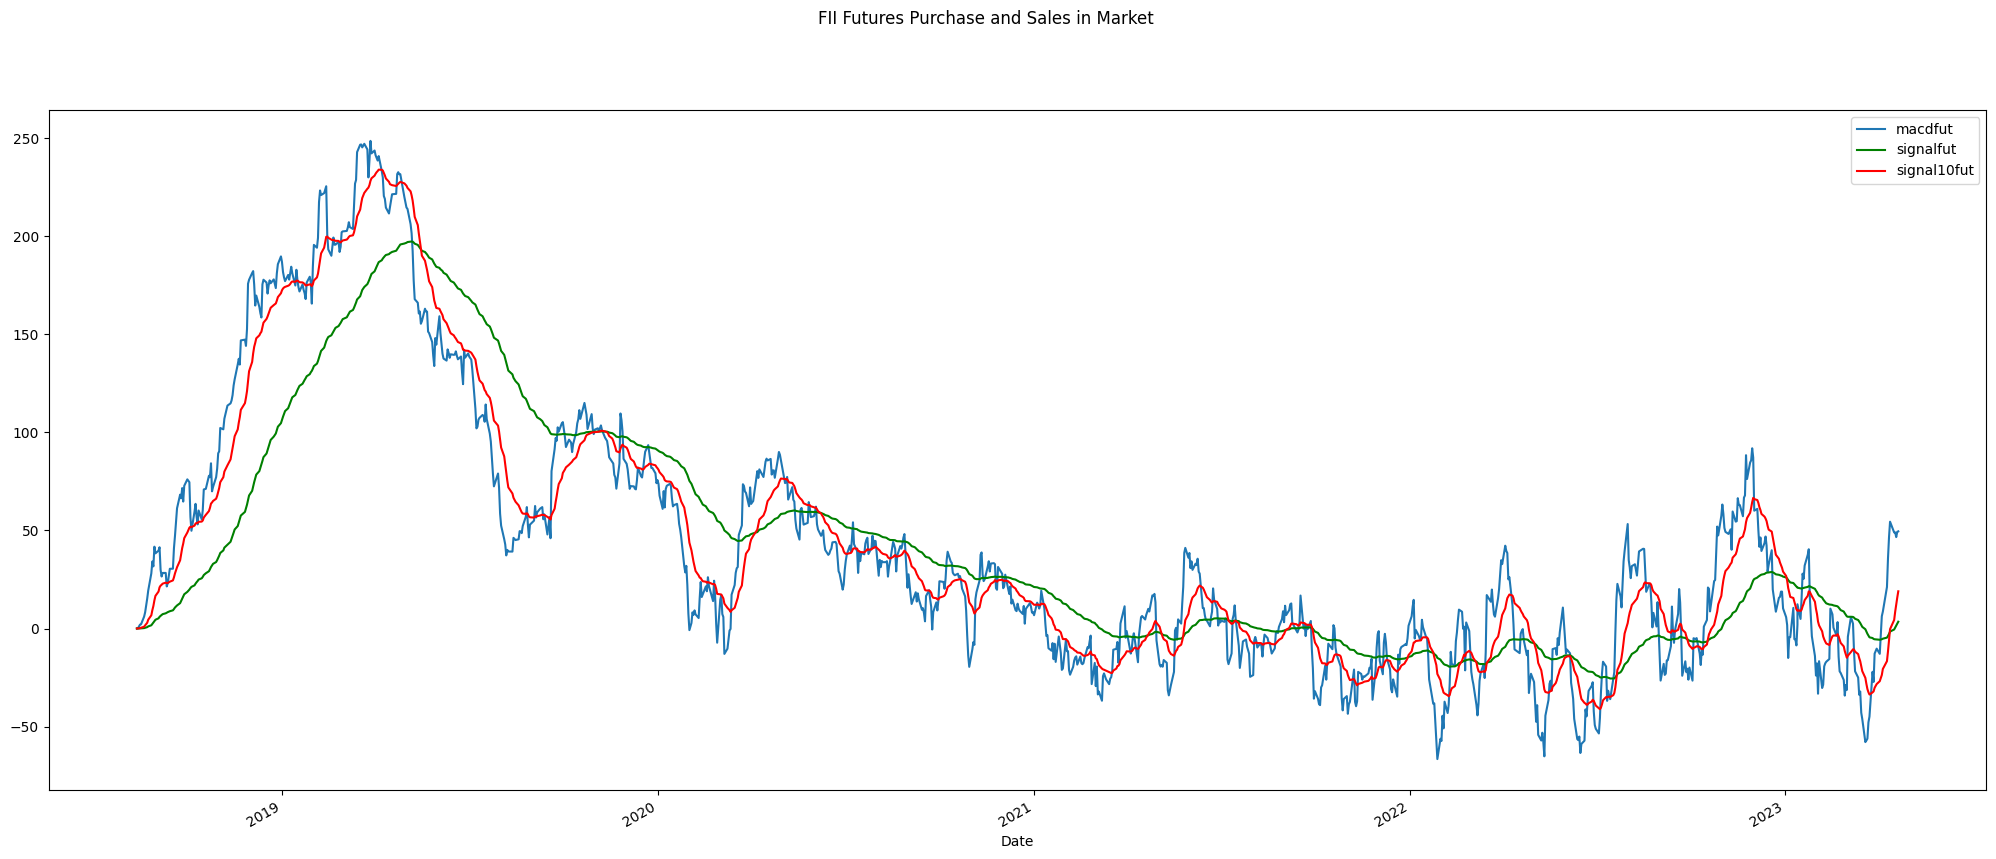

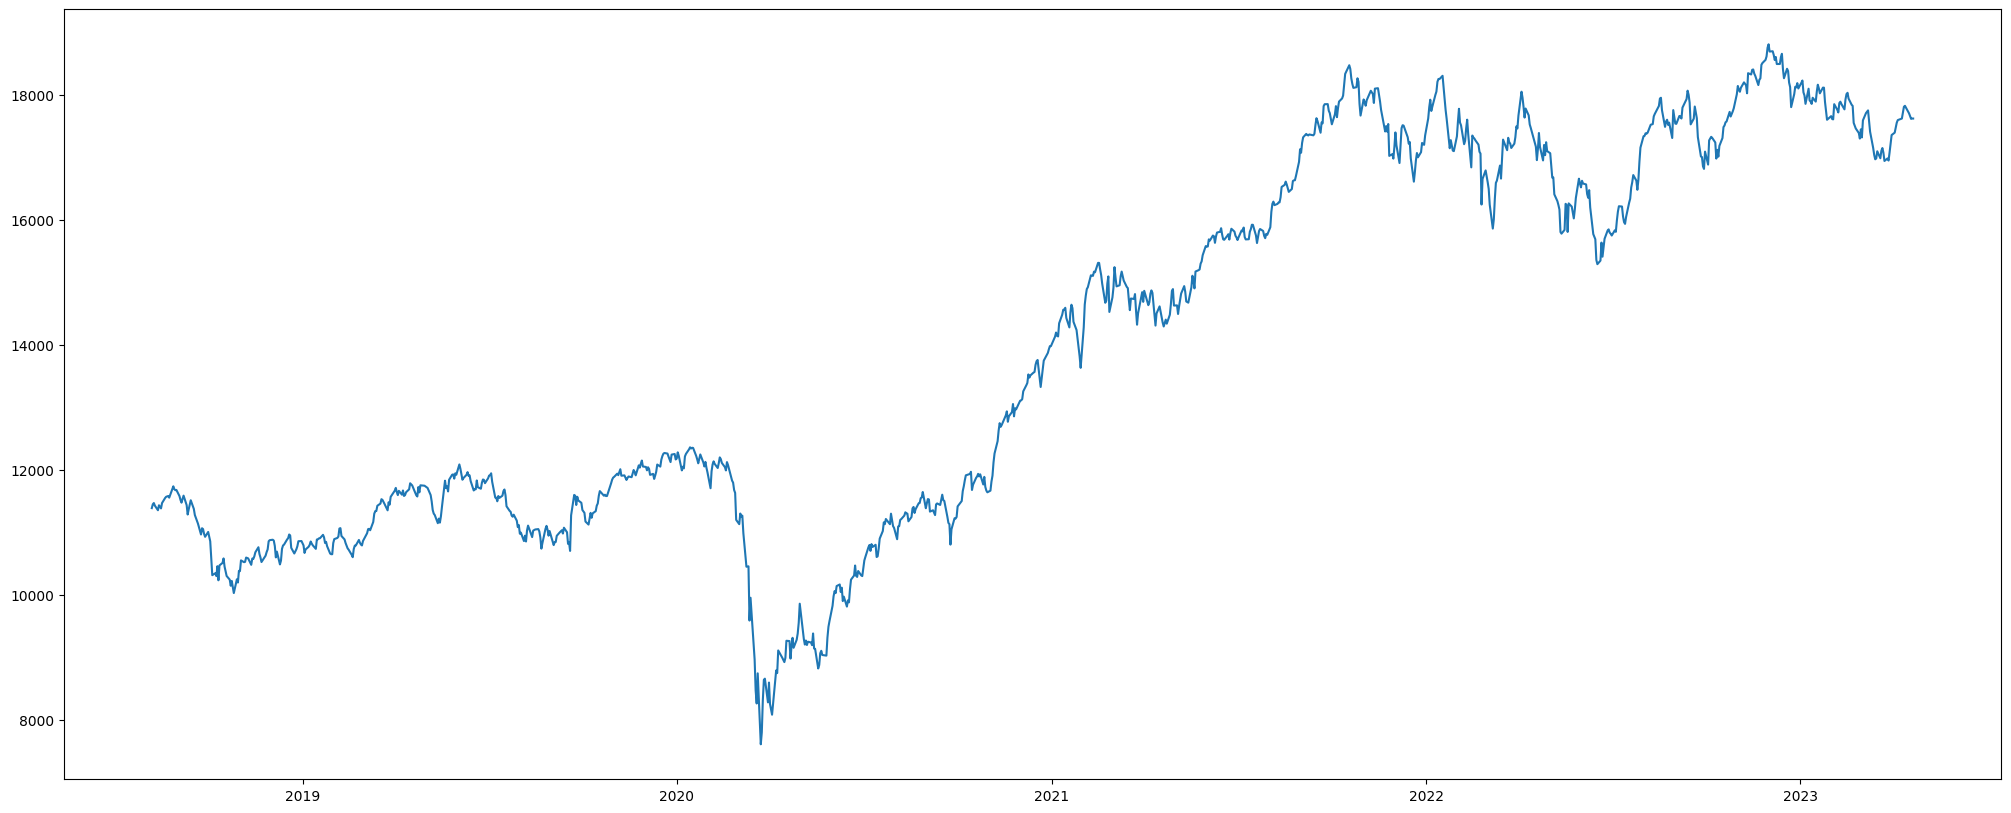

In [22]:
fii_fig['macdfut'].plot(figsize=(25,10))
fii_fig['signalfut'].plot(color='g')
fii_fig['signal10fut'].plot(color='r')
#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('FII Futures Purchase and Sales in Market')
plt.legend()
plt.show()
plt.figure(figsize=(25,10))
plt.plot(nifty.Close)
plt.show()

# Plot FII minus DII

In [23]:
fii_fig['macdy']=fii_fig['Cash'].ewm(span=50, adjust=False).mean()-fii_fig['Cash'].ewm(span=100, adjust=False).mean()
fii_fig['signaly']=fii_fig['macdy'].ewm(span=25,adjust=False).mean()
fii_fig['signal10y']=fii_fig['macdy'].ewm(span=10,adjust=False).mean()
fii_fig['histy']=fii_fig['macdy']-fii_fig['signaly']

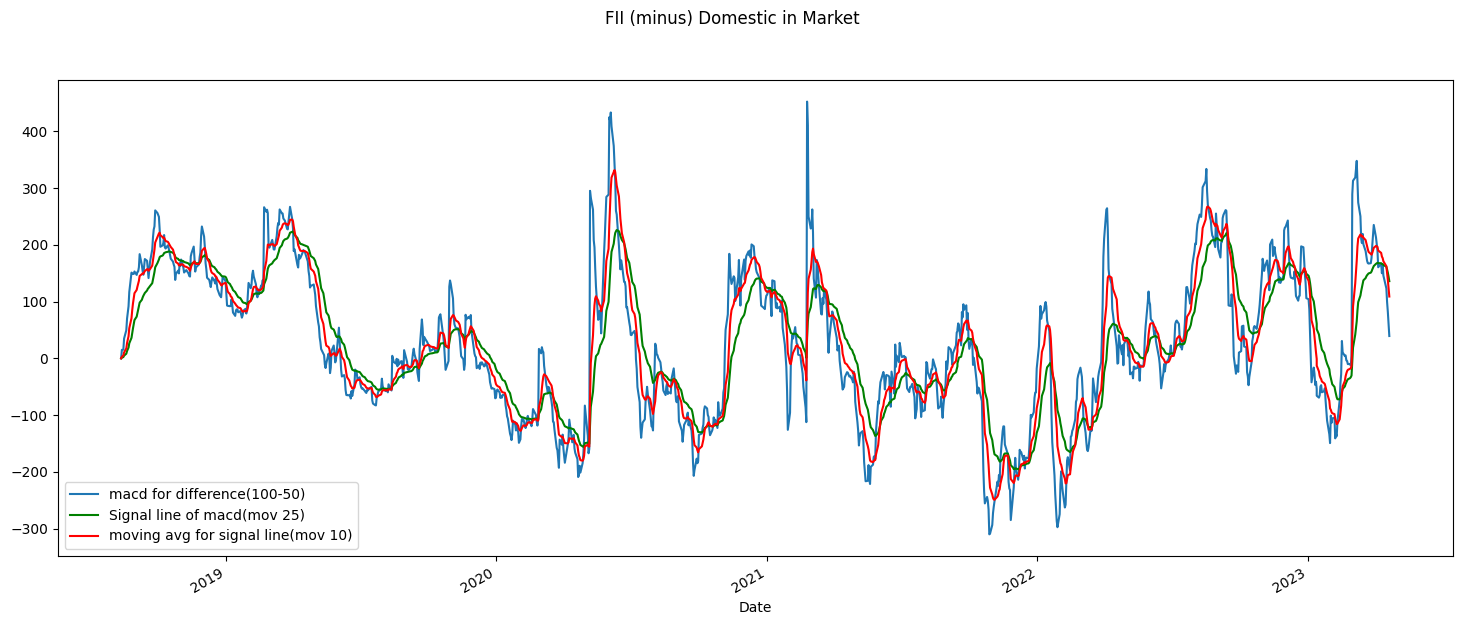

In [24]:
fii_fig['macdy'].plot(figsize=(18,7),label= 'macd for difference(100-50)')
fii_fig['signaly'].plot(color='g',label='Signal line of macd(mov 25)')
fii_fig['signal10y'].plot(color='r',label='moving avg for signal line(mov 10)')
#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('FII (minus) Domestic in Market')
plt.legend(loc='lower left')
plt.show()

In [25]:
fii_fig['macdy']=fii_fig['Cash'].ewm(span=100, adjust=False).mean()-fii_fig['Cash'].ewm(span=250, adjust=False).mean()
fii_fig['signaly']=fii_fig['macdy'].ewm(span=45,adjust=False).mean()
fii_fig['signal10y']=fii_fig['macdy'].ewm(span=20,adjust=False).mean()
fii_fig['histy']=fii_fig['macdy']-fii_fig['signaly']

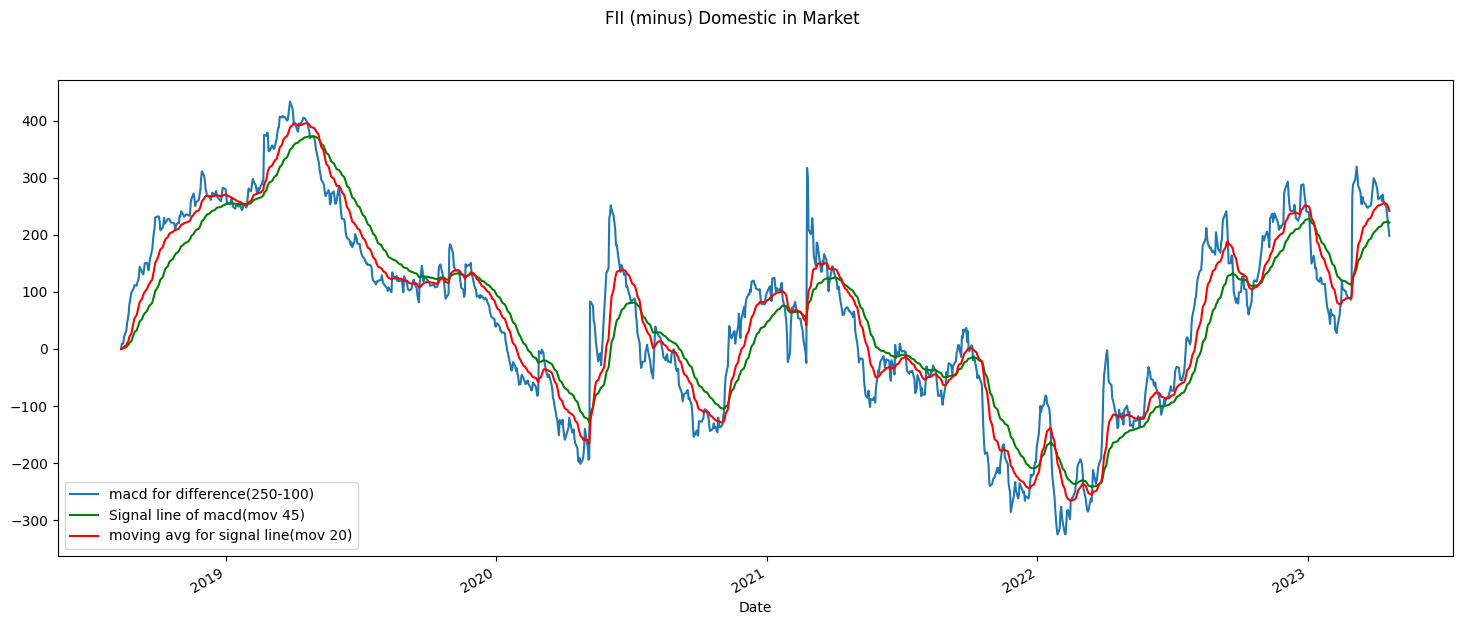

In [26]:
fii_fig['macdy'].plot(figsize=(18,7),label= 'macd for difference(250-100)')
fii_fig['signaly'].plot(color='g',label='Signal line of macd(mov 45)')
fii_fig['signal10y'].plot(color='r',label='moving avg for signal line(mov 20)')
#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('FII (minus) Domestic in Market')
plt.legend(loc='lower left')
plt.show()

In [27]:
fii_fig['macd']=fii_fig['DIIcash'].ewm(span=50, adjust=False).mean()-fii_fig['DIIcash'].ewm(span=200, adjust=False).mean()
fii_fig['signal']=fii_fig['macd'].ewm(span=35,adjust=False).mean()
fii_fig['signal10']=fii_fig['macd'].ewm(span=10,adjust=False).mean()
fii_fig['hist']=fii_fig['macd']-fii_fig['signal']

In [28]:
fii_fig['macdx']=fii_fig['FIICash'].ewm(span=50, adjust=False).mean()-fii_fig['FIICash'].ewm(span=200, adjust=False).mean()
fii_fig['signalx']=fii_fig['macdx'].ewm(span=35,adjust=False).mean()
fii_fig['signal10x']=fii_fig['macdx'].ewm(span=10,adjust=False).mean()
fii_fig['histx']=fii_fig['macdx']-fii_fig['signalx']

# Plot FII , DII , Difference comparison

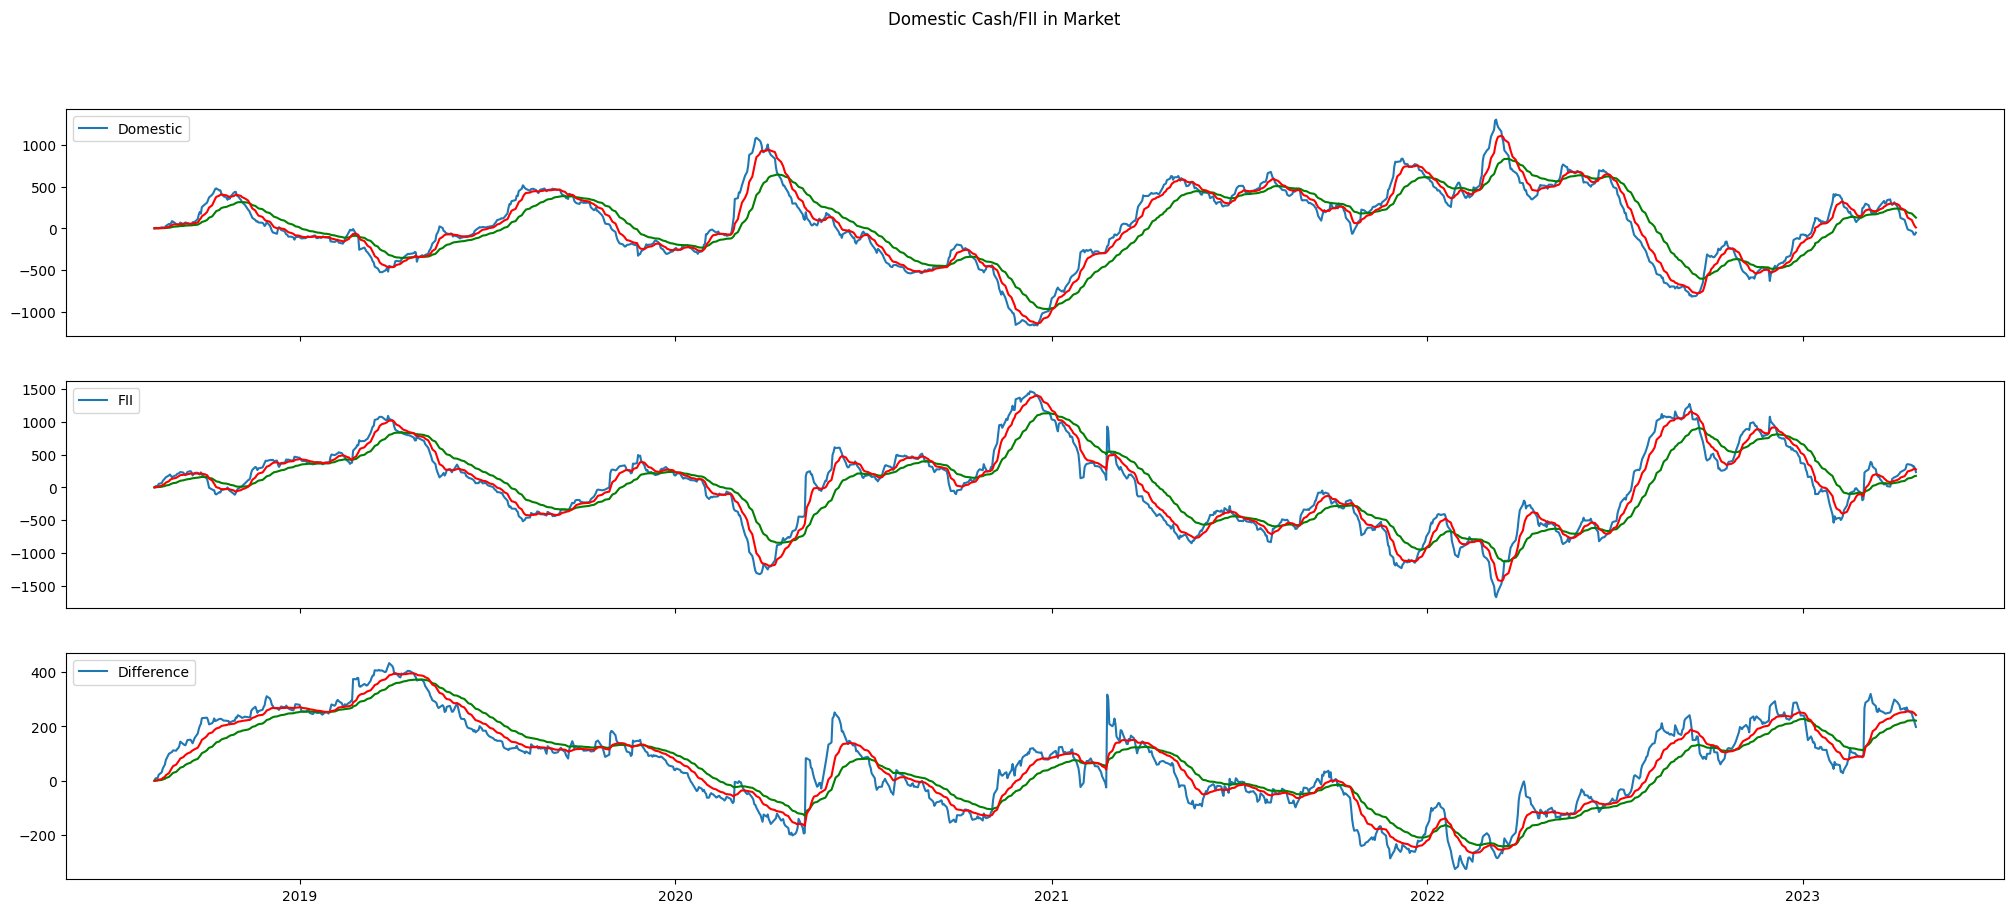

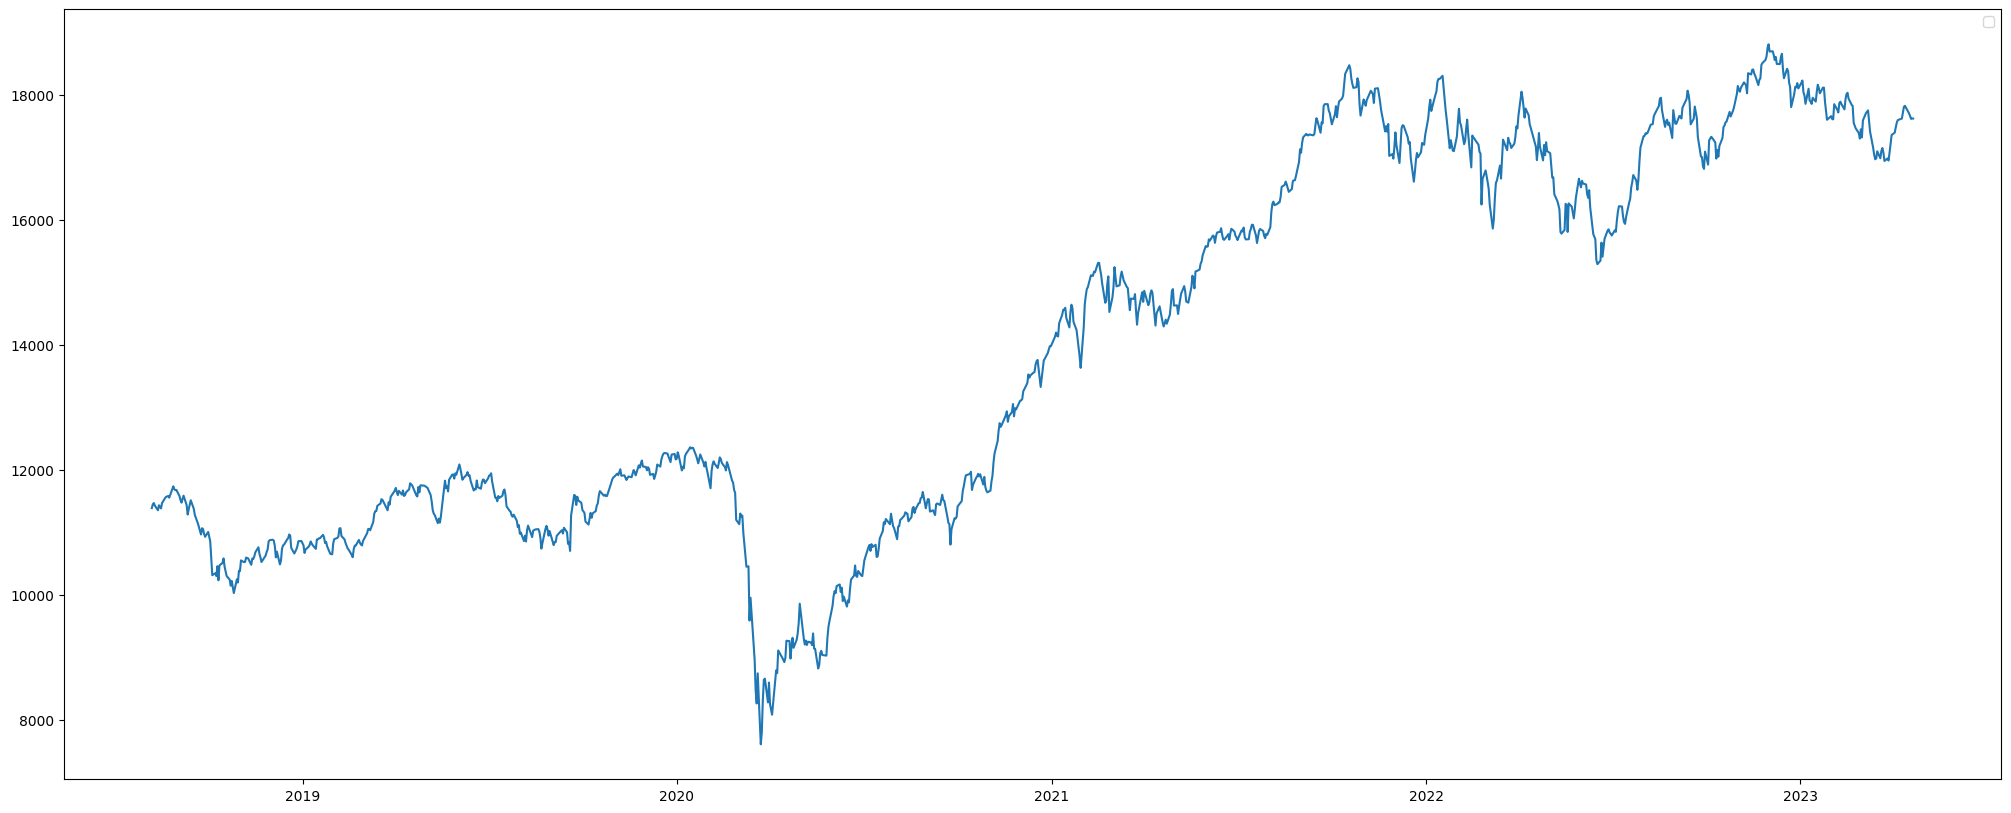

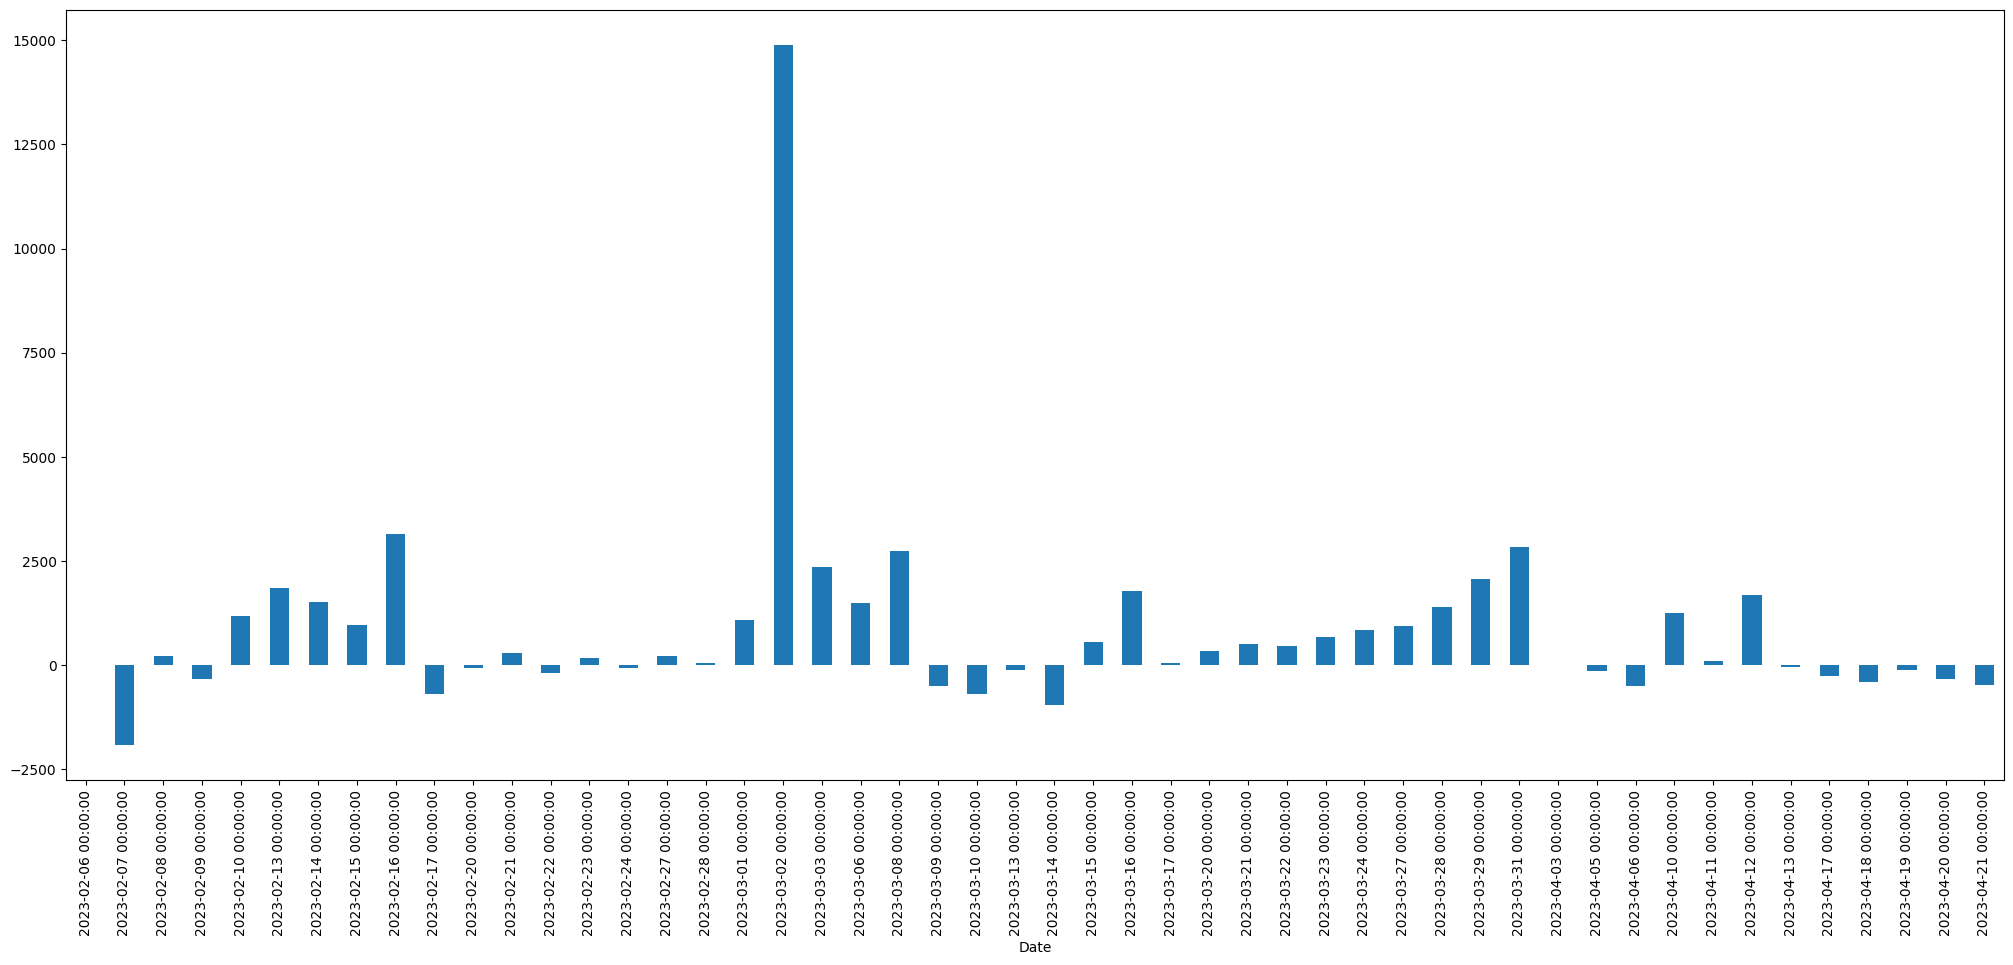

In [29]:
fig,ax=plt.subplots(3,1,figsize=(25,10),sharex=True)
ax[0].plot(fii_fig['macd'], label='Domestic')
ax[0].plot(fii_fig['signal'],color='g')
ax[0].plot(fii_fig['signal10'],color='r')
ax[2].plot(fii_fig['macdy'],label='Difference')
ax[2].plot(fii_fig['signaly'],color='g')
ax[2].plot(fii_fig['signal10y'],color='r')
#plt.plot(fii_fig.loc[:, :].index)
ax[1].plot(fii_fig['macdx'],label='FII')
ax[1].plot(fii_fig['signalx'],color='g')
ax[1].plot(fii_fig['signal10x'],color='r')

#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('Domestic Cash/FII in Market')
ax[0].legend(loc='upper left')
ax[1].legend(loc='upper left')
ax[2].legend(loc='upper left')
plt.show()
plt.figure(figsize=(25,10))
plt.plot(nifty.Close)
#plt.xaxis.set_major_locator(mloc)
plt.legend()
plt.show()
plt.figure(figsize=(25,10))
fii_fig['Cash'][-50:].plot.bar()
plt.show()

In [30]:
fii_fig.tail(2)

,FIIcall,FIIput,FIIFuture,FIIFutOI,FIICash,DIIcash,Cash,macdfut,signalfut,signal10fut,...,signal10y,histy,macd,signal,signal10,hist,macdx,signalx,signal10x,histx
Date,,,,,,,,,,,,,,,,,,,,,
2023-04-20,91.8,45.3,476,-33.8,-1169.0,833.0,-336.0,49.327936,2.478495,15.759072,...,246.225670,-10.652872,-75.534548,138.639515,23.540494,-214.174063,290.406940,171.229170,282.135761,119.177770
2023-04-21,-56.6,14.0,105,-31.5,-2117.0,1633.0,-484.0,49.543665,3.459019,18.976653,...,241.626471,-23.321441,-51.797732,128.059668,9.842635,-179.857400,232.952151,174.658224,273.193286,58.293927


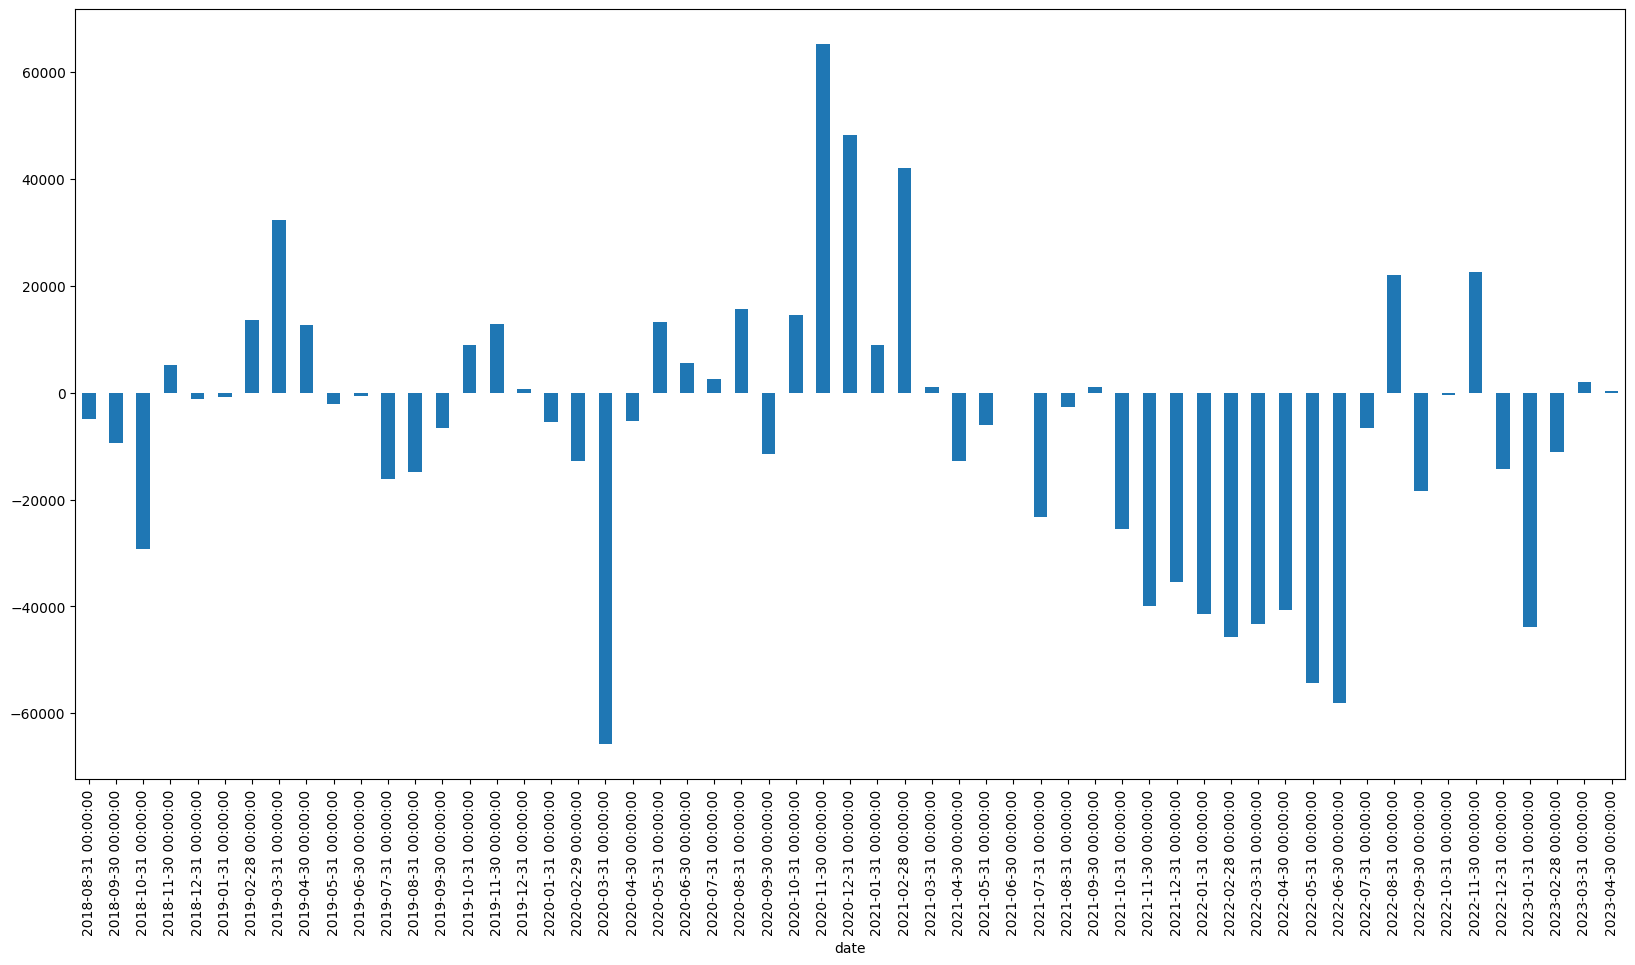

In [31]:
fii_fig=fii_fig.reset_index()
fii_fig['date']=pd.to_datetime(fii_fig['Date'])
fii_fig = fii_fig.set_index('date')
fii_fig.FIICash.resample('M').sum().plot(kind='bar',figsize=(20,10))
plt.show()

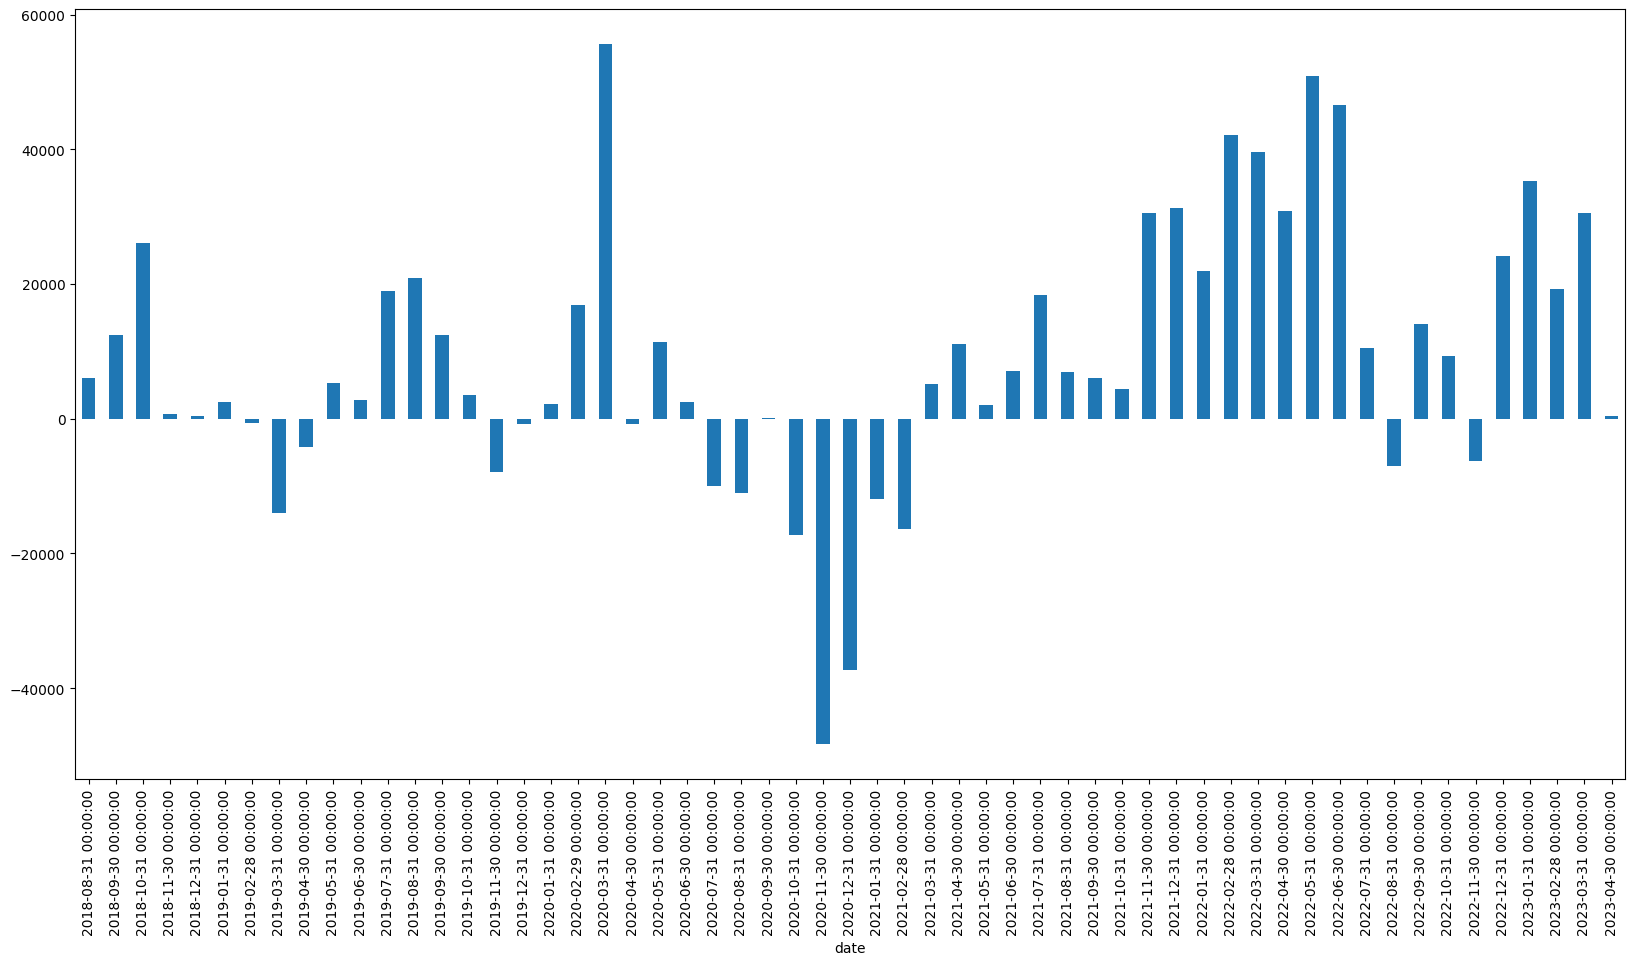

In [32]:
fii_fig.DIIcash.resample('M').sum().plot(kind='bar',figsize=(20,10))
plt.show()

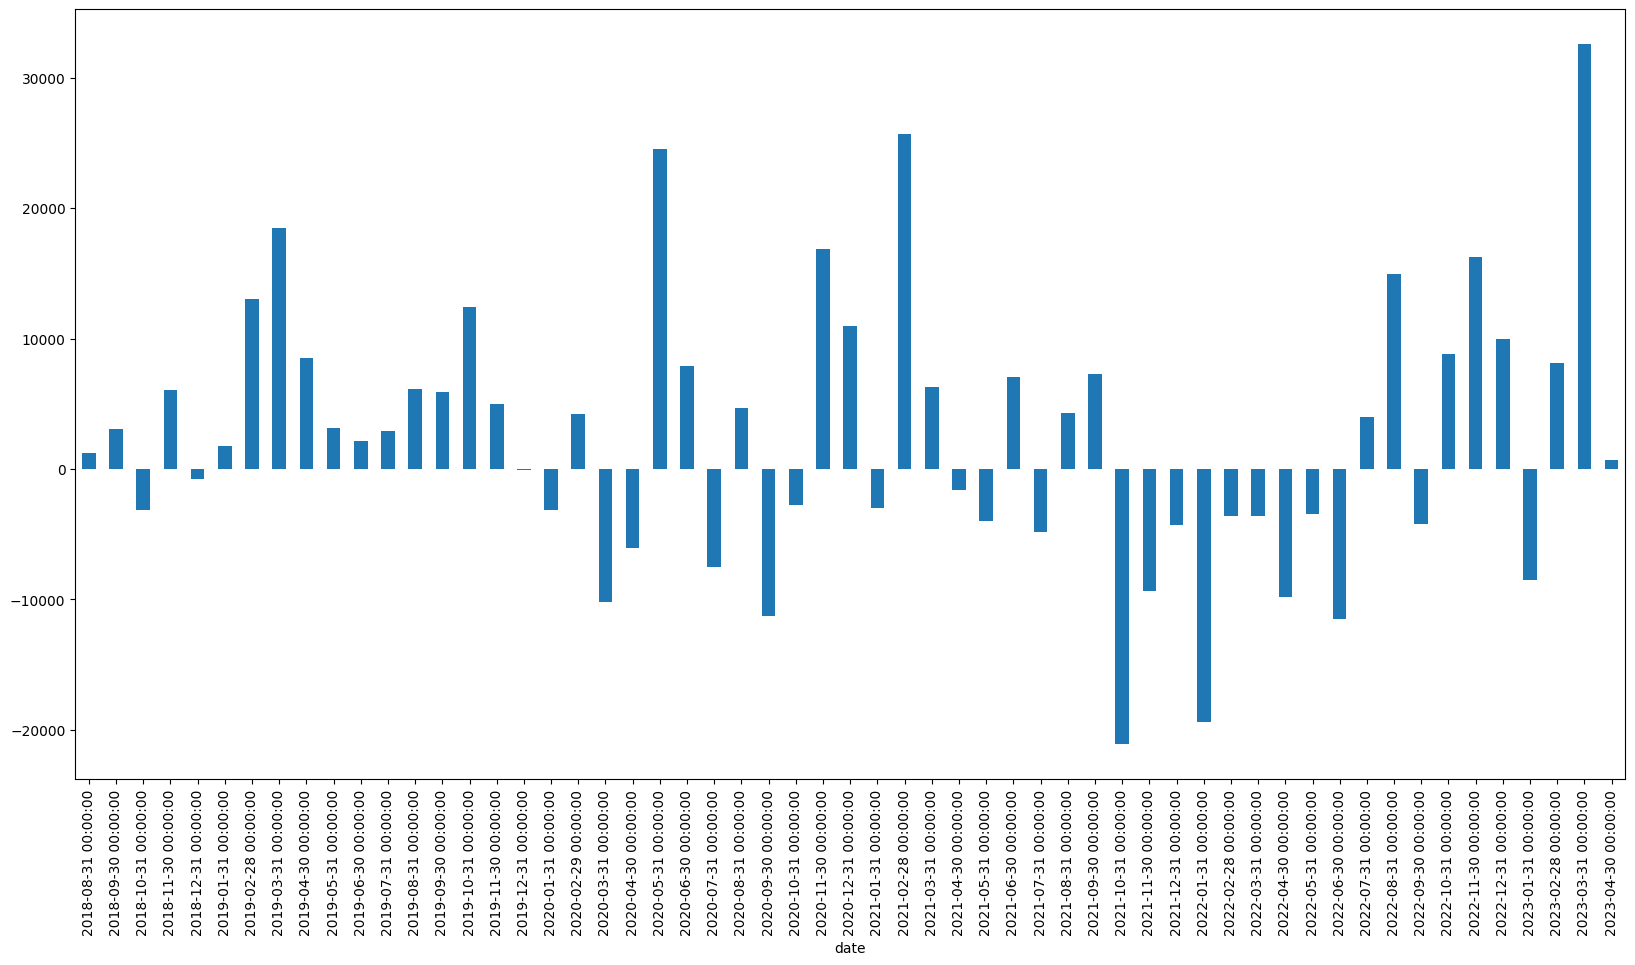

In [33]:
fii_fig.Cash.resample('M').sum().plot(kind='bar',figsize=(20,10))
plt.show()


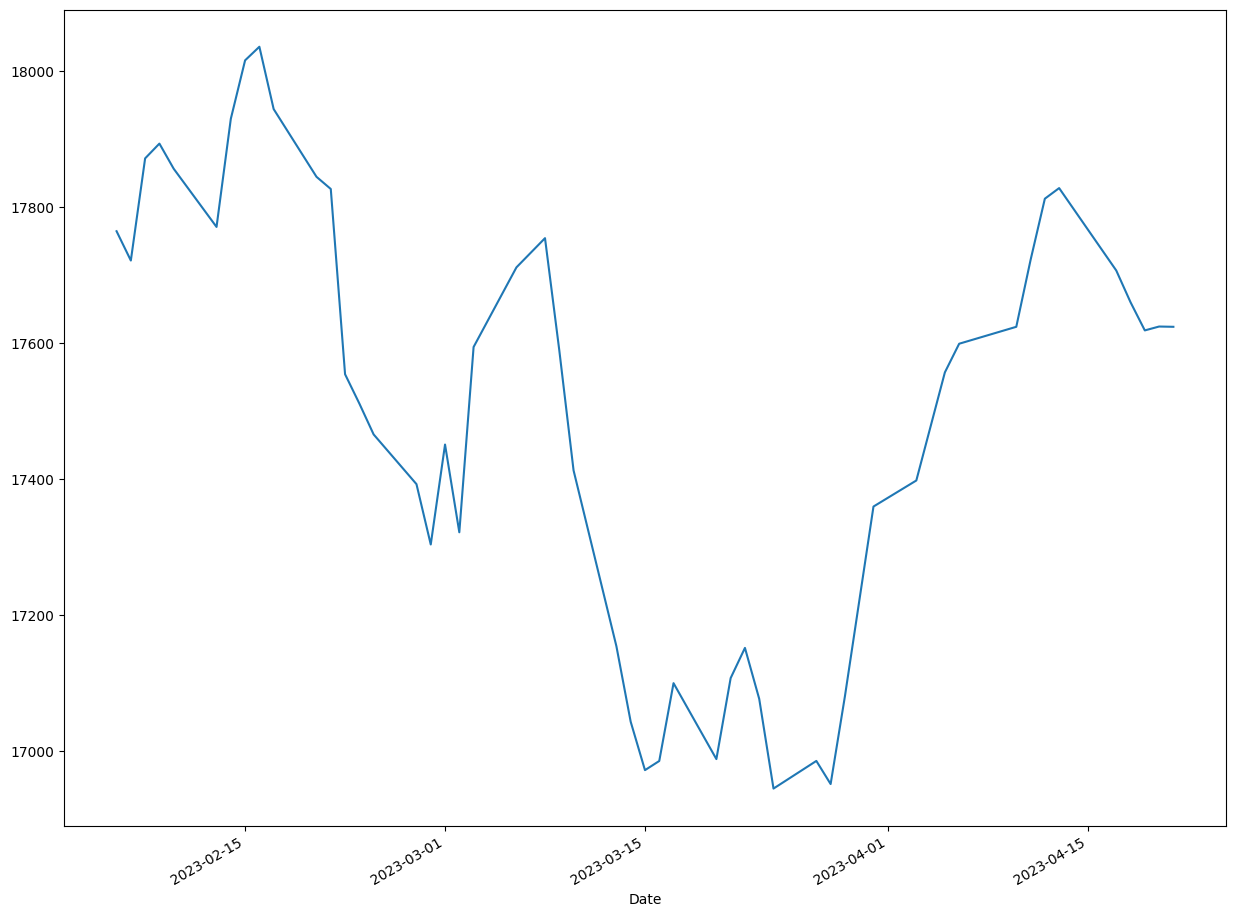

In [34]:
nifty['Close'][-50:].plot(figsize=(15,12));

In [35]:
fii_fig['MA200']=fii_fig.FIICash.rolling(window=200).mean()
fii_fig['MA50']=fii_fig.FIICash.rolling(window=50).mean()

In [36]:
fii_fig['macd']=fii_fig['FIICash'].ewm(span=50, adjust=False).mean()-fii_fig['FIICash'].ewm(span=100, adjust=False).mean()
fii_fig['signal']=fii_fig['macd'].ewm(span=50,adjust=False).mean()
fii_fig['signal10']=fii_fig['macd'].ewm(span=10,adjust=False).mean()
fii_fig['hist']=fii_fig['macd']-fii_fig['signal'] 


In [37]:
fii_fig['macd_dom']=fii_fig['DIIcash'].ewm(span=20, adjust=False).mean()-fii_fig['DIIcash'].ewm(span=200, adjust=False).mean()
fii_fig['signal_dom']=fii_fig['DIIcash'].ewm(span=10,adjust=False).mean()
fii_fig['signal_dom_10']=fii_fig['DIIcash'].ewm(span=10,adjust=False).mean()
fii_fig['hist_dom']=fii_fig['macd_dom']-fii_fig['signal_dom']

In [38]:
nif.reset_index(inplace=True)
fii_fig.reset_index(inplace=True)
# Convert the 'Date' column in both DataFrames to the same data type
nif['Date'] = pd.to_datetime(nif['Date'])
fii_fig['Date'] = pd.to_datetime(fii_fig['Date'])

# Merge nif and fii_fig DataFrames on the 'Date' column
merged_df = pd.merge(nif, fii_fig, on='Date')


In [39]:
df = fii_fig

fig = go.Figure()
for c in ['macd','signal']:
    fig.add_traces(go.Scatter(x=df.index, y=df[c], mode='lines', name = c))
fig.update_layout(title_text="FII & Nifty")
fig.show()

# Plot Smart Money (FII)

In [40]:
from plotly.subplots import make_subplots
df=fii_fig.reset_index()
nif.reset_index(inplace=True)
fig = make_subplots(
    rows=2, cols=1,shared_xaxes=True,vertical_spacing=0.02,
    subplot_titles=("Smart Money","Nifty"))

fig.add_trace(go.Scatter(x=df.Date, y=df['macd'], mode='lines', name = 'macd'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=df.Date, y=df['signal'], mode='lines', name = 'signal'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date, y=df['signal10'], mode='lines', name = 'signal10'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=nif.Date, y=nif['Close'], mode='lines', name = 'Close'),
              row=2, col=1)

fig.update_layout(title_text="Smart Money And Nifty")

fig.show()

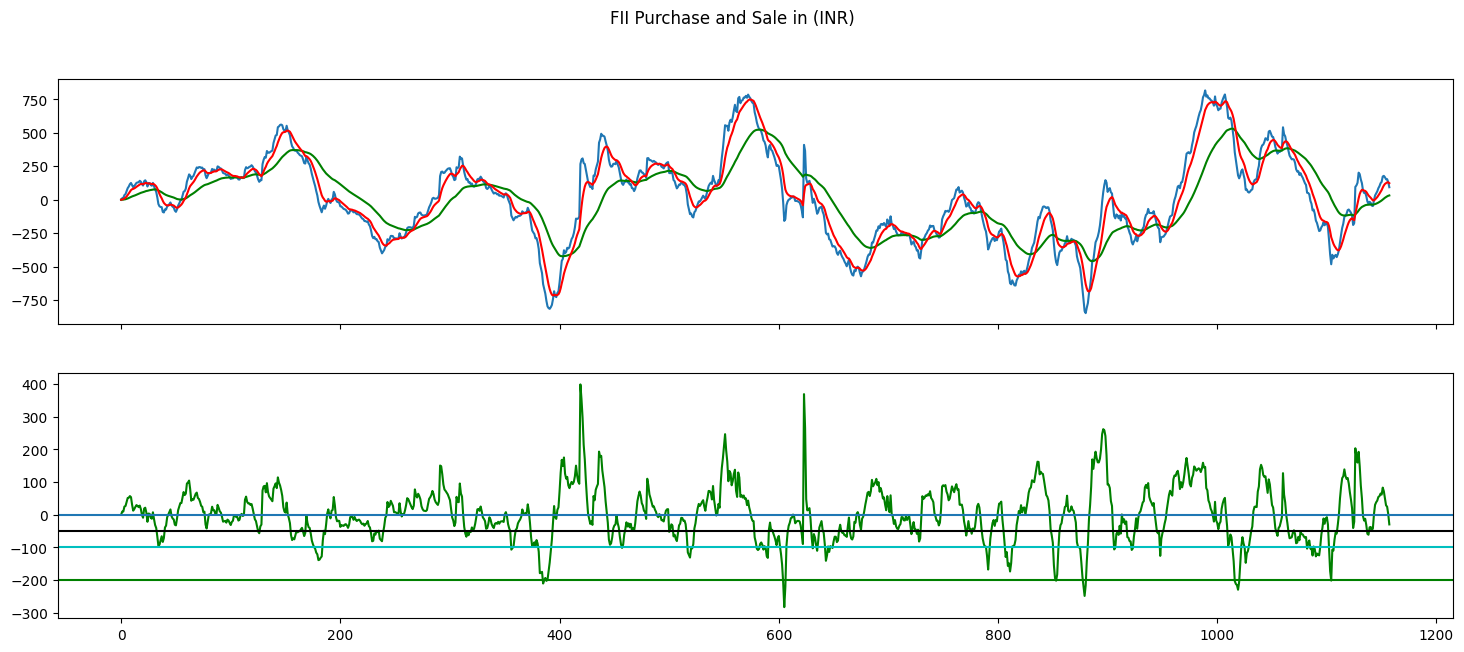

In [41]:
fig, ax = plt.subplots(2,1, figsize=(18,7),sharex=True)
ax[0].plot(fii_fig['macd'])
ax[0].plot(fii_fig['signal'],color='g')
ax[0].plot(fii_fig['signal10'],color='r')
ax[1].plot(fii_fig['macd']-fii_fig['signal10'],color='g')
plt.axhline(y=0)
plt.axhline(y=-200,color='g')
plt.axhline(y=-100,color='c')
plt.axhline(y=-50,color='k')
plt.suptitle('FII Purchase and Sale in (INR)')

plt.show()

In [42]:
from plotly.subplots import make_subplots
df=fii_fig.reset_index()
nif.reset_index(inplace=True)
fig = make_subplots(
    rows=2, cols=1,shared_xaxes=True,vertical_spacing=0.02,
    subplot_titles=("Smart Money DII","Nifty"))

fig.add_trace(go.Scatter(x=df.Date, y=df['macd_dom'], mode='lines', name = 'macd'),
              row=1, col=1)
fig.add_trace(go.Scatter(x=df.Date,y=df['macd_dom'].rolling(window=10).mean(),mode='lines',name='moving-average 10'),
              row=1, col=1)

fig.add_trace(go.Scatter(x=nif.Date, y=nif['Close'], mode='lines', name = 'Close'),
              row=2, col=1)

fig.update_layout(title_text="DII Money And Nifty")

fig.show()

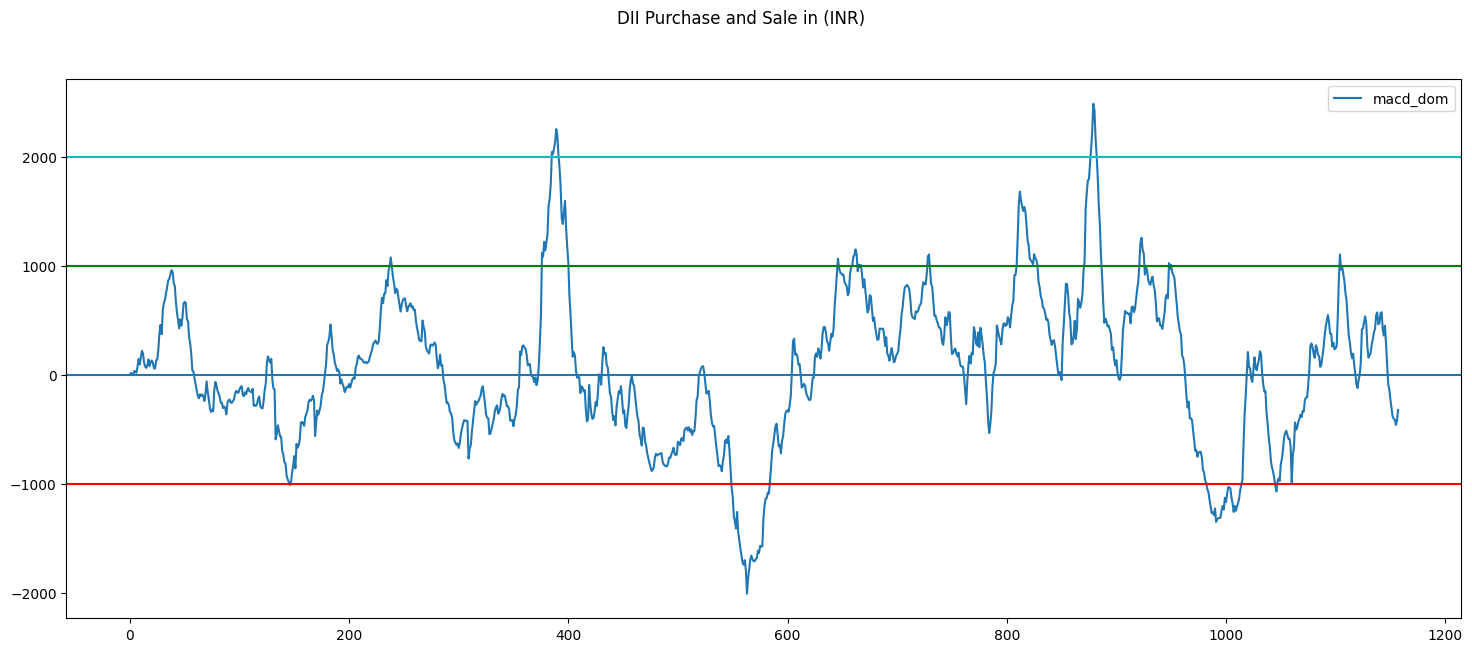

In [43]:
fii_fig['macd_dom'].plot(figsize=(18,7))
plt.axhline(y=0)
plt.axhline(y=1000,color='g')
plt.axhline(y=2000,color='c')
plt.axhline(y=-1000,color='r')
plt.suptitle('DII Purchase and Sale in (INR)')
plt.legend()
plt.show()

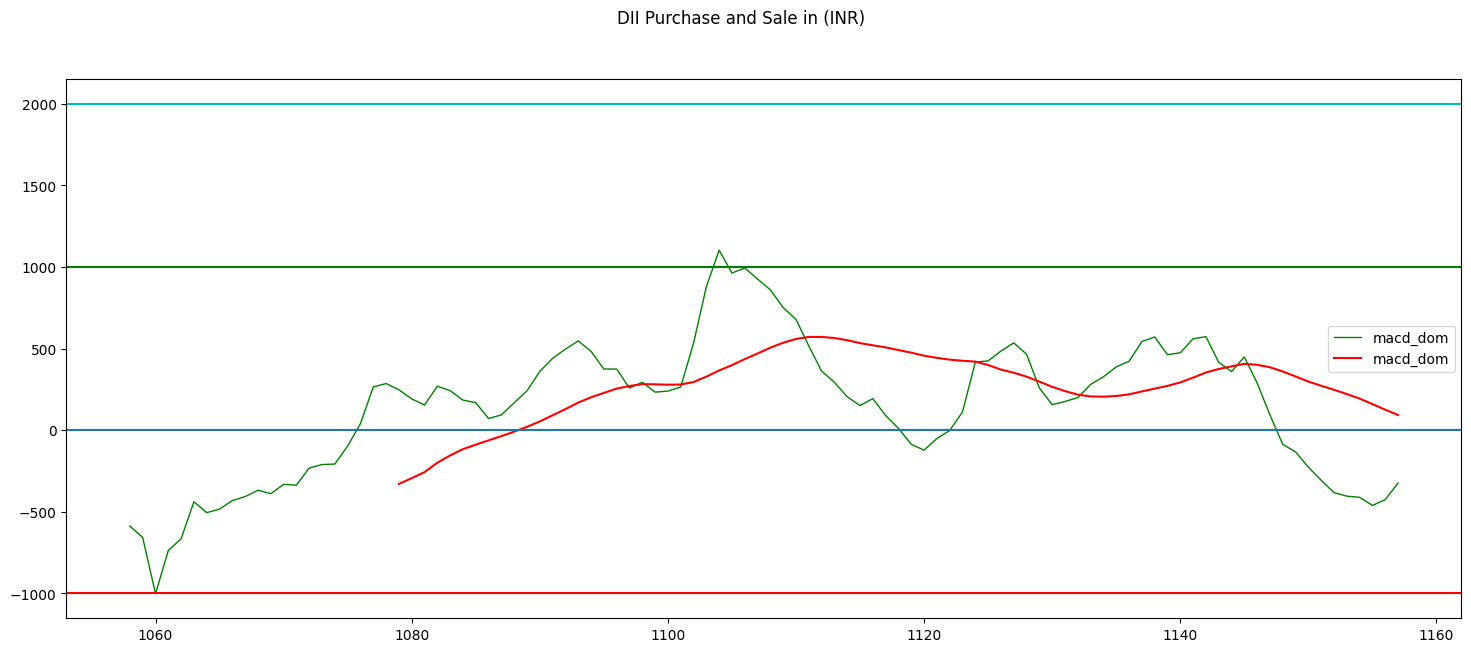

In [44]:
fii_fig['macd_dom'][-100:].plot(figsize=(18,7),color='g',lw=1.0)
fii_fig['macd_dom'][-100:].rolling(window=22).mean().plot(color='r')
plt.axhline(y=0)
plt.axhline(y=1000,color='g')
plt.axhline(y=2000,color='c')
plt.axhline(y=-1000,color='r')
plt.suptitle('DII Purchase and Sale in (INR)')
plt.legend()
plt.show()

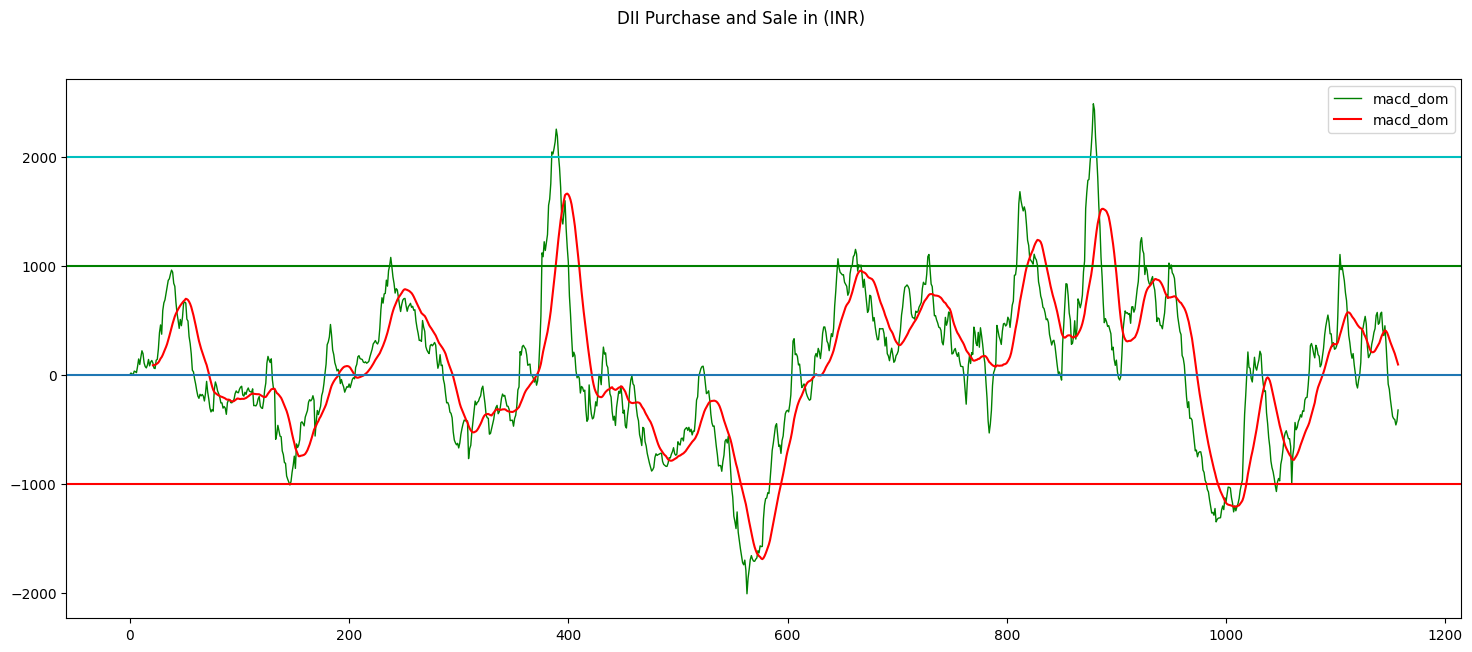

In [45]:
fii_fig['macd_dom'][:].plot(figsize=(18,7),color='g',lw=1.0)
fii_fig['macd_dom'][:].rolling(window=22).mean().plot(color='r')
plt.axhline(y=0)
plt.axhline(y=1000,color='g')
plt.axhline(y=2000,color='c')
plt.axhline(y=-1000,color='r')
plt.suptitle('DII Purchase and Sale in (INR)')
plt.legend()
plt.show()

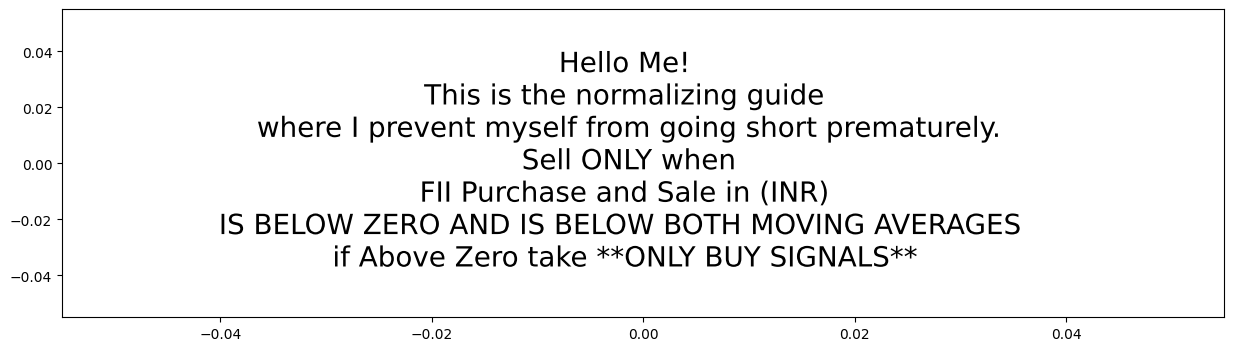

In [46]:
import matplotlib.patheffects as path_effects

fig = plt.figure(figsize=(15, 4))
text = fig.text(0.5, 0.5, 'Hello Me!\n This is the normalizing guide '
                          '\n where I prevent myself from going short prematurely.\n Sell ONLY when' 
                           '\nFII Purchase and Sale in (INR)\n'
                           'IS BELOW ZERO AND IS BELOW BOTH MOVING AVERAGES \n'
                           'if Above Zero take **ONLY BUY SIGNALS**',
                ha='center', va='center', size=20)
plt.plot(path_effects=[path_effects.Normal(),path_effects.Normal()])
text.set_path_effects([path_effects.Normal()])


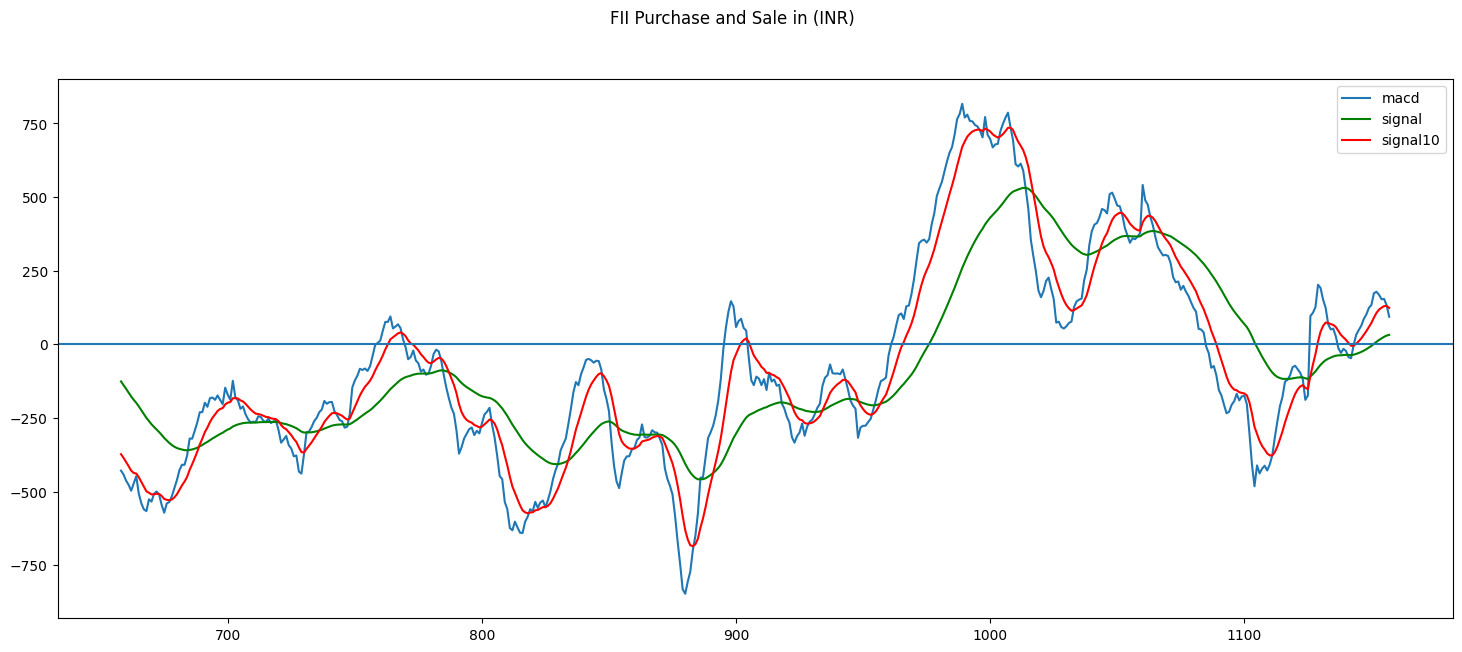

In [47]:
fii_fig['macd'][-500:].plot(figsize=(18,7))
fii_fig['signal'][-500:].plot(color='g')
fii_fig['signal10'][-500:].plot(color='r')
#plt.plot(fii_fig.loc[:, :].index)
plt.suptitle('FII Purchase and Sale in (INR)')
plt.axhline(y=0)
plt.legend()
plt.show()

In [48]:
merged_df.columns

Index(['Date', 'Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume', 'date',
       'FIIcall', 'FIIput', 'FIIFuture', 'FIIFutOI', 'FIICash', 'DIIcash',
       'Cash', 'macdfut', 'signalfut', 'signal10fut', 'histfut', 'macdy',
       'signaly', 'signal10y', 'histy', 'macd', 'signal', 'signal10', 'hist',
       'macdx', 'signalx', 'signal10x', 'histx', 'MA200', 'MA50', 'macd_dom',
       'signal_dom', 'signal_dom_10', 'hist_dom'],
      dtype='object')

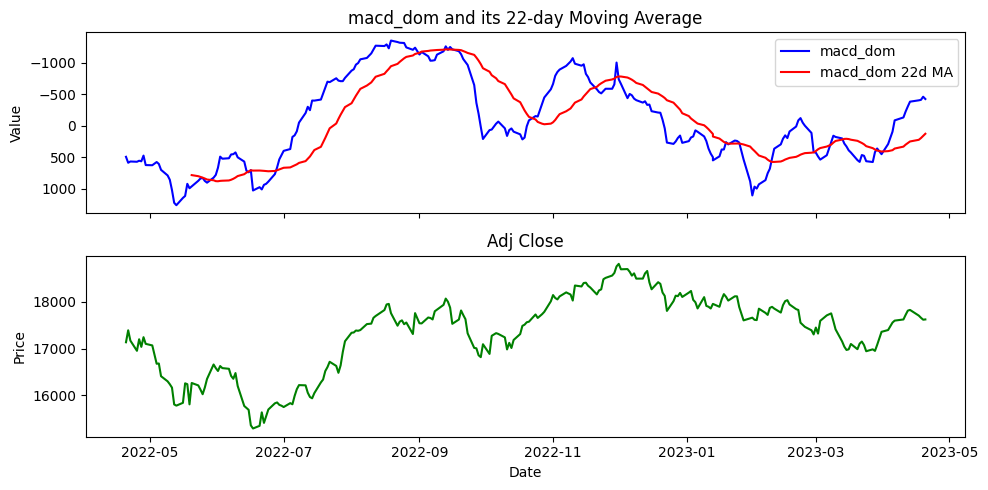

In [52]:
# Select the last 250 data points
last_250_points = merged_df.tail(250)

# Calculate the 22-day moving average of 'macd_dom'
last_250_points['macd_dom_22d_ma'] = last_250_points['macd_dom'].rolling(window=22).mean()

fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10, 5), sharex=True)

# Plot 'macd_dom' and its 22-day moving average in the first subplot
ax1.plot(last_250_points['Date'], last_250_points['macd_dom'], label='macd_dom', color='b')
ax1.plot(last_250_points['Date'], last_250_points['macd_dom_22d_ma'], label='macd_dom 22d MA', color='r')
# Invert the y-axis
ax1.invert_yaxis()
ax1.set_title('macd_dom and its 22-day Moving Average')
ax1.set_ylabel('Value')
ax1.legend()

# Plot 'Adj Close' in the second subplot
ax2.plot(last_250_points['Date'], last_250_points['Adj Close'], label='Adj Close', color='g')
ax2.set_title('Adj Close')
ax2.set_xlabel('Date')
ax2.set_ylabel('Price')


# Display the subplots
plt.tight_layout()
plt.show()


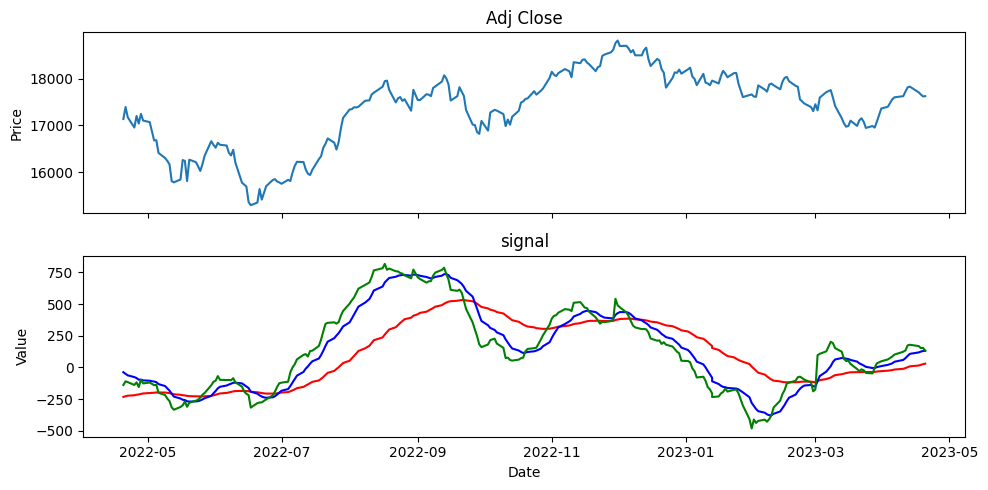

In [50]:
import matplotlib.pyplot as plt
# Select the last 250 data points
merged_df = merged_df.tail(250)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(10,5), sharex=True)

# Plot 'Adj Close' as a time series
ax1.plot(merged_df['Date'], merged_df['Adj Close'], label='Adj Close')
ax1.set_title('Adj Close')
ax1.set_ylabel('Price')

# Plot 'signal_dom_10' as a time series
ax2.plot(merged_df['Date'], merged_df['signal'], label='signal', color='r')
ax2.plot(merged_df['Date'], merged_df['signal10'], label='signal', color='b')
ax2.plot(merged_df['Date'], merged_df['macd'], label='macd', color='g')
ax2.set_title('signal')
ax2.set_xlabel('Date')
ax2.set_ylabel('Value')

# Display the subplots
plt.tight_layout()
plt.show()
